# __Machine Learning: Regression - Predicting Energy Efficiency of Buildings__
___

In [1]:
# importing the necessary libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('darkgrid')
pd.options.display.max_rows = 20

In [2]:
data = pd.read_csv('energydata_complete.csv')

In [3]:
# Rename columns
columns = {'Appliances':'appliance_wh', 
           'lights':'light_wh', 
           'T1':'kitchen_temp', 
           'RH_1':'kitchen_humid', 
           'T2':'liv_room_temp', 
           'RH_2':'liv_room_humid', 
           'T3':'laund_room_temp', 
           'RH_3':'laund_room_humid', 
           'T4':'office_room_temp', 
           'RH_4':'office_room_humid', 
           'T5':'bathroom_temp', 
           'RH_5':'bathroom_humid', 
           'T6':'out_northside_temp', 
           'RH_6':'out_northside_humid', 
           'T7':'ironing_room_temp', 
           'RH_7':'ironing_room_humid',
           'T8':'teen_room_temp', 
           'RH_8':'teen_room_humid', 
           'T9':'parent_room_temp', 
           'RH_9':'parent_room_humid', 
           'T_out':'outside_temp', 
           'Press_mm_hg':'outside_pressure', 
           'RH_out':'outside_humid', 
           'Tdewpoint':'dewpoint_temp', 
           'rv1':'rv_1', 
           'rv2':'rv_2',
           'Windspeed':'windspeed',
           'Visibility':'visibility'
          }

data.rename(columns=columns, inplace=True)
data.head()

,date,appliance_wh,light_wh,kitchen_temp,kitchen_humid,liv_room_temp,liv_room_humid,laund_room_temp,laund_room_humid,office_room_temp,...,parent_room_temp,parent_room_humid,outside_temp,outside_pressure,outside_humid,windspeed,visibility,dewpoint_temp,rv_1,rv_2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


### Data Exploration
___
* Check for duplicate entries
* Check for null values

In [4]:
data.duplicated().sum()

0

In [5]:
data.isnull().sum()

date                 0
appliance_wh         0
light_wh             0
kitchen_temp         0
kitchen_humid        0
liv_room_temp        0
liv_room_humid       0
laund_room_temp      0
laund_room_humid     0
office_room_temp     0
                    ..
parent_room_temp     0
parent_room_humid    0
outside_temp         0
outside_pressure     0
outside_humid        0
windspeed            0
visibility           0
dewpoint_temp        0
rv_1                 0
rv_2                 0
Length: 29, dtype: int64

### Feature Engineering
___
The main feature to be analyzed here is the `date` column.

In [6]:
# Change date-time to python datetime object
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S')

data['month'] = data['date'].dt.month_name()
data['day'] = data['date'].dt.weekday_name
data['hour'] = data['date'].dt.hour

In [7]:
data['month'].unique()

array(['January', 'February', 'March', 'April', 'May'], dtype=object)

In [8]:
data['day'].unique()

array(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
       'Sunday'], dtype=object)

In [9]:
data['hour'].unique()

array([17, 18, 19, 20, 21, 22, 23,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
       10, 11, 12, 13, 14, 15, 16], dtype=int64)

As can be seen above, the dataset contains data that span the first 5 months of the year: _January, February, March, April, May_.

These months can be grouped into:
1. Winter Months
    - January
    - February
2. Spring Months
    - March
    - April
    - May

In [10]:
data.columns

Index(['date', 'appliance_wh', 'light_wh', 'kitchen_temp', 'kitchen_humid',
       'liv_room_temp', 'liv_room_humid', 'laund_room_temp',
       'laund_room_humid', 'office_room_temp', 'office_room_humid',
       'bathroom_temp', 'bathroom_humid', 'out_northside_temp',
       'out_northside_humid', 'ironing_room_temp', 'ironing_room_humid',
       'teen_room_temp', 'teen_room_humid', 'parent_room_temp',
       'parent_room_humid', 'outside_temp', 'outside_pressure',
       'outside_humid', 'windspeed', 'visibility', 'dewpoint_temp', 'rv_1',
       'rv_2', 'month', 'day', 'hour'],
      dtype='object')

### Investigating Trends Across the Various Months
---
Considering the different seasons(Winter & Spring), I will investigate some of the features and see how they vary across the various months, as a result of seasonal change.

After using the pandas __groupby__ function on the `month` column, the months will automatically be sorted in alphabetical order. However, for the purpose of thus analysis, the months and days need to be ordered naturally.

In [11]:
months = ['January', 'February', 'March', 'April', 'May']
days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

data['month'] = pd.Categorical(data['month'], months)
data['day'] = pd.Categorical(data['day'], days)

data['day'].unique()

[Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday]
Categories (7, object): [Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday]

In [12]:
# Columns to investigate
cols_inv = ['appliance_wh', 'light_wh', 'out_northside_temp',
            'out_northside_humid', 'windspeed', 'visibility',
            'dewpoint_temp', 'outside_pressure', 'outside_temp', 'outside_humid']

def month_mean():
    df_list = list()
    for i in range(len(cols_inv)):
        df = data.groupby('month')[cols_inv[i]].mean()
        df_list.append(df)
        
    month_data = pd.concat(df_list, axis=1).reset_index()
    
    return month_data

month_data = month_mean()
month_data

,month,appliance_wh,light_wh,out_northside_temp,out_northside_humid,windspeed,visibility,dewpoint_temp,outside_pressure,outside_temp,outside_humid
0,January,97.026010,4.722793,3.894547,92.175166,4.795517,39.790554,1.986071,758.947467,4.128936,86.607461
1,February,100.945881,6.343391,4.880271,79.961223,4.847821,38.762332,2.193894,753.387033,4.817301,84.230125
2,March,96.953405,3.915771,5.856132,54.873425,3.992832,40.116599,2.135540,755.840916,5.439415,80.734991
3,April,98.888889,2.416667,9.276930,34.089611,3.652431,36.322338,4.387639,754.606319,8.513449,77.209954
4,May,94.199325,1.770049,15.090683,21.342920,3.079419,36.939138,7.984661,755.898430,13.762717,71.402673


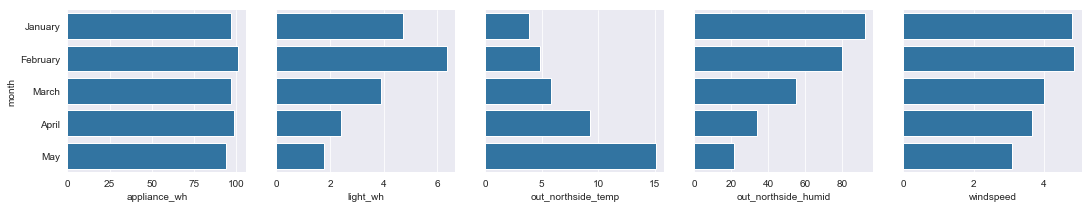

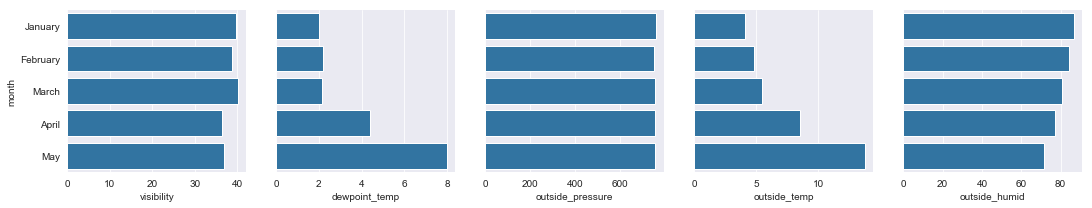

In [13]:
sns.PairGrid(month_data, x_vars=cols_inv[0:5], y_vars=['month'], height=3).map(sns.barplot)
sns.PairGrid(month_data, x_vars=cols_inv[5:10], y_vars=['month'], height=3).map(sns.barplot)


From the visualizations above, a number of inferences that correlate with seasonal change can be made:
1. `appliance_wh`, `visibility`, & `outside_pressure` relatively remain stable across all months(regardless of the season), with very little changes.
2. `out_northside_temp`, `dewpoint_temp`, & `outside_temp` gradually increase as the season changes from Winter to Spring. This change takes place mostly at March, which signifies the beginning of the Spring season. The Spring season is characterized by general temperature increase, compared to Winter.
3. `outside_humid` & `out_northside_humid` which are the relative humidities gradually reduce as the season changes from Winter to Spring. This can be explained by the increase in temperature that occurs at this period.
4. `light_wh` which is the lights energy consumption reduces during the Spring season. The Spring season(March - May) is characterized by longer days and shorter nights, hence the reduced need for lights. It is safe to assume that the days are remarkably brighter than the nights.

In [14]:
def plot_heat_map(df, feature, title):
    """
    This is a Helper Function to visualize the energy usage.
    """

    fig, ax = plt.subplots(2, 3, figsize=(20,20), squeeze=False)
    fig.delaxes(ax[1][2])
    fig.suptitle(title, fontsize=20)
    for ax, month in zip(ax.flatten(), months):
        day_hr = df[df['month'] == month][['day', 'hour', feature]]
        day_hr_pv = pd.pivot_table(day_hr, values=feature, index=['hour'], columns=['day'])
        ax.set(title=month)
        sns.heatmap(day_hr_pv, square=True, ax=ax, cmap='YlGnBu', linewidth=.5)

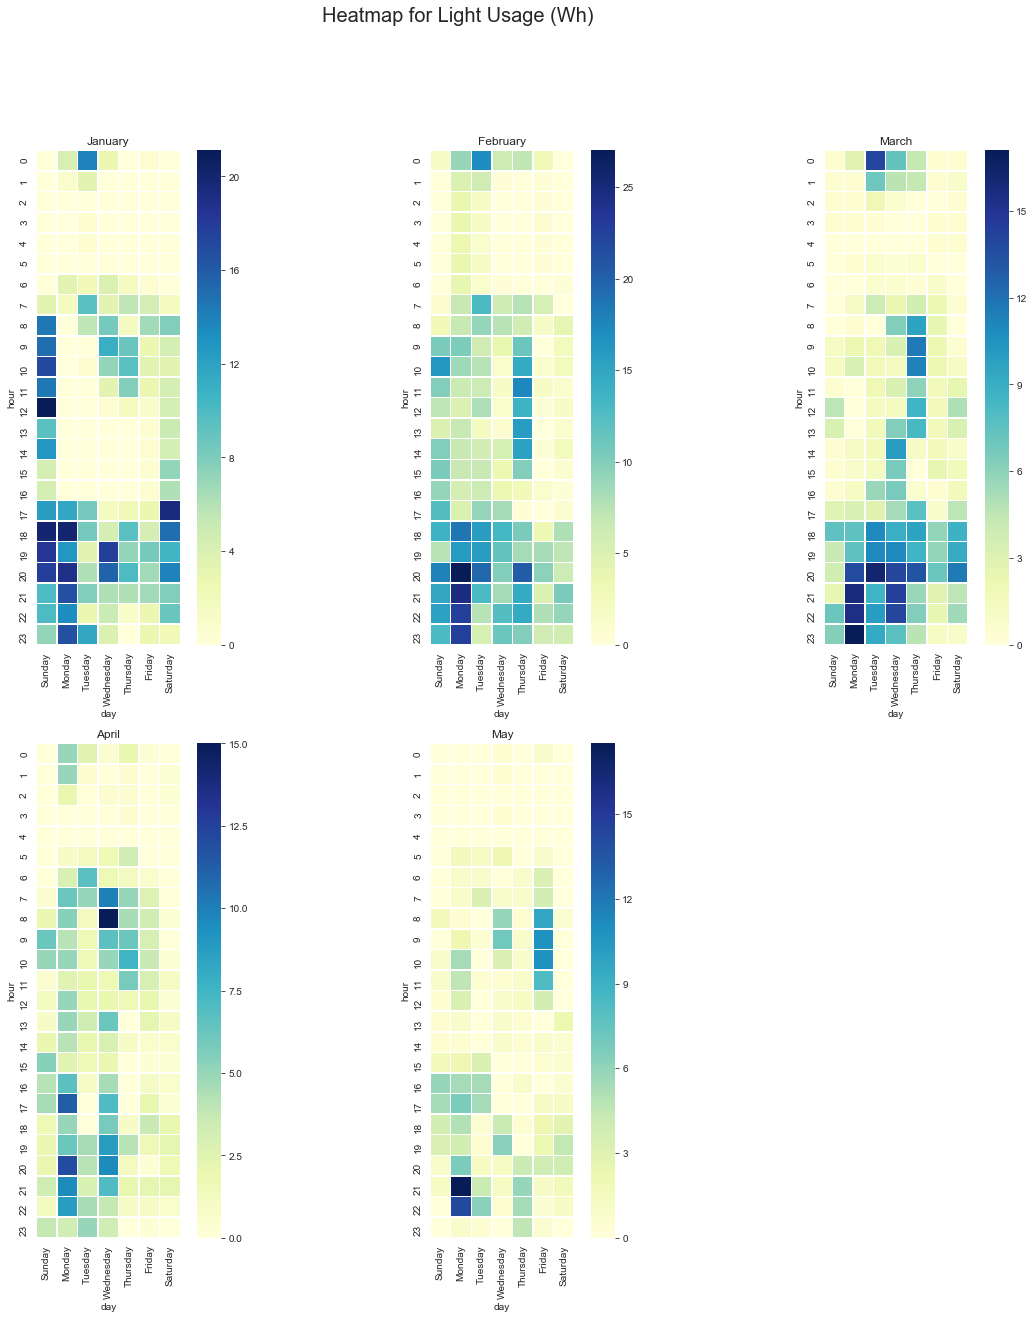

In [15]:
plot_heat_map(data, feature='light_wh', title='Heatmap for Light Usage (Wh)')

### Analysis of Heatmap for Light Usage (Wh)
- Generally, light usage is high on weekdays from the hours of 5pm till 12am. Usually, these periods are not work hours, meaning that most people would be in their homes. This is also coupled with the fact that it is generally darker during these hours.
- Taking a critical look at Saturday and Sunday (Weekends), it is noticed that light usage intensifies between 8am till 11pm. However, Saturday is less indicative of this trend, and I will assume that there must be a reason for this.
- During the Spring months (March, April, May), light usage is considerably lower than that of the Winter months (January, February). A reasonable cause for this could be that there are longer days than nights during Spring.

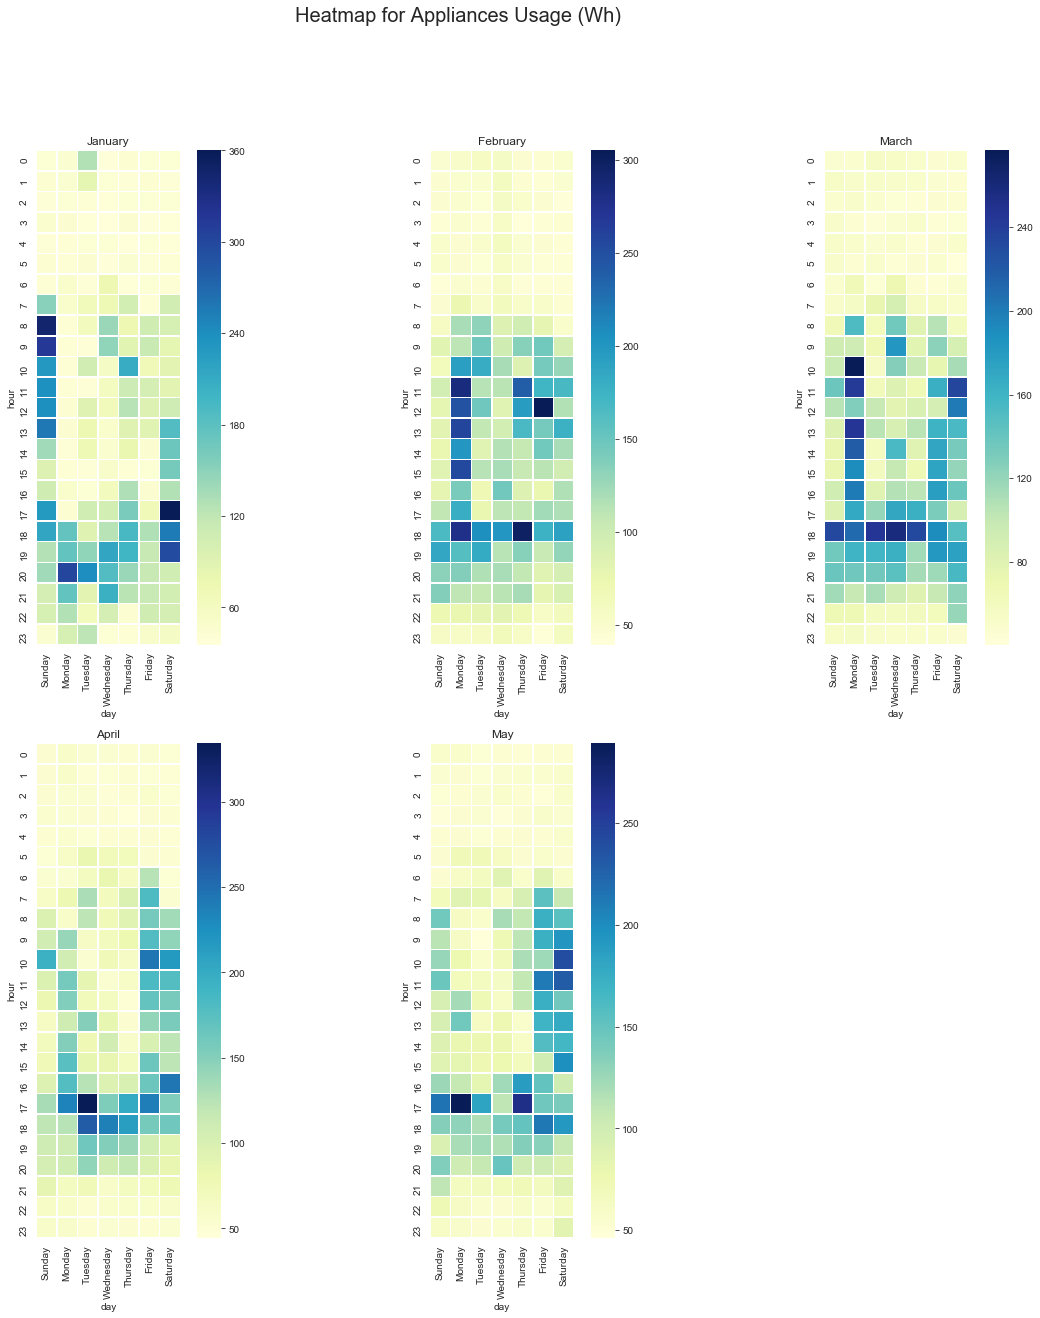

In [16]:
plot_heat_map(data, feature='appliance_wh', title='Heatmap for Appliances Usage (Wh)')

### Analysis of Heatmap for Appliances Usage (Wh)
- Generally, appliance usage intensifies between the hours of 7am till 9pm. This explains that appliances are less used during sleeping hours 10pm - 6am.

## Features Selection for Machine Learning
---
Using my discretion, there are a number of criteria:
- The `month` and `day` features are ordinal in nature and are not needed.This is because the model will make wrong assumptions that some entries are more important than others.
- The `date` is not needed. Moreover, useful features such as `hour` have been engineered from it.
- The `appliance_wh` is the target variable, so it will be excluded from the predictors.

In [17]:
# Checking the correlation of the various features with the target variable - appliance_wh
data_corr = data.corr()['appliance_wh'].abs().sort_values(ascending=False)
data_corr.shape

(29,)

In [18]:
# Setting 0.05 as a threshold to filter-away features with weak correlations
strong_corr = data_corr[data_corr > 0.05]
strong_corr

appliance_wh           1.000000
hour                   0.216792
light_wh               0.197278
outside_humid          0.152282
liv_room_temp          0.120073
out_northside_temp     0.117638
outside_temp           0.099155
teen_room_humid        0.094039
windspeed              0.087122
kitchen_humid          0.086031
laund_room_temp        0.085060
out_northside_humid    0.083178
liv_room_humid         0.060465
ironing_room_humid     0.055642
kitchen_temp           0.055447
parent_room_humid      0.051462
Name: appliance_wh, dtype: float64

In [19]:
features = strong_corr.index.drop('appliance_wh')
target = 'appliance_wh'

## Machine Learning
___
Here, I will try out different linear models and see how they perform on the dataset.

### __Error Metrics__
The following error metrics will be used to evaluate the various models:
- *Mean Absolute Error (MAE)* is the sum of the average absolute error between the predicted and true values.
\begin{equation*}
    MAE = \frac{1}{n} \sum_{i} |y_{i} - \hat{y}_{i}|
\end{equation*}
where $y_{i}$ is the true value and $\hat{y}_{i}$ is the predicted value. The MAE is measured in the same scale as the predicted output, which in this case is `Wh`.
- *Residual Sum of Squares (RSS)* measures how well a model approximates the data. RSS also explains the variance in the representation of the dataset by the model.
\begin{equation*}
    RSS = \sum_{i} (y_{i} - \hat{y}_{i})^2
\end{equation*}
- *Mean Squared Error (MSE)* measures the average of the squares of the errors (i.e the average squared difference between a true value and a predicted value). 
\begin{equation*}
    MSE = \frac{1}{n} \sum_{i} (y_{i} - \hat{y}_{i})^2
\end{equation*}
- *Root Mean Squared Error (RMSE)* is the squared root of MSE, and estimated the standard deviation of the residuals (errors). A low RMSE would mean the error made by the model has a small deviation from the true values.
\begin{equation*}
    RMSE = \sqrt{MSE}
\end{equation*}
- *R-Squared Score (R2 score)* is also known as the coefficient of determination, and is used to determine the goodness of a fit of a model. Its value ranges from 1 - 0 and usually the higher the number, the better the model.
\begin{equation*}
    R^2 = 1 - \frac{SS_{res}}{SS_{tot}} = 1 - \frac{\sum_{i} (y_{i} - \hat{y}_{i})^2}{\sum_{i} (y_{i} - \bar{y}_{i})^2}
\end{equation*}
where $SS_{res}$ is the residual sum of squares (RSS) and $SS_{tot}$ is the total sum of squares, and $\bar{y}$ is the mean of the observed data.

In [20]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [21]:
def performance(actual, predicted):
    '''
    Calculates the performance metrics.
    Metrics:
        -MSE -RMSE -R-squared -MAE -RSS
    '''
    mse = mean_squared_error(actual, predicted)
    print("Mean Squared Error: ", round(mse, 3))
    
    rmse = np.sqrt(mse)
    print("Root Mean Squared Error: ", round(rmse, 3))
    
    r2 = r2_score(actual, predicted)
    print("R-squared score: ", round(r2, 3))
    
    mae = mean_absolute_error(actual, predicted)
    print("Mean Absolute Error (MAE): ", round(mae, 3))
    
    rss = np.sum(np.square(actual - predicted))
    print("Residual Sum of Squares (RSS): ", round(rss, 3))
    
    return {'mse':mse, 'rmse':rmse, 'r2_score':r2, 'mae':mae, 'rss':rss}

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.3, random_state=42)

lr = LinearRegression()
lr.fit(x_train, y_train)
lr_pred = lr.predict(x_test)

performance(y_test, lr_pred)

Mean Squared Error:  8665.032
Root Mean Squared Error:  93.086
R-squared score:  0.159
Mean Absolute Error (MAE):  53.67
Residual Sum of Squares (RSS):  51305653.396


{'mse': 8665.03181824477,
 'rmse': 93.08615266646683,
 'r2_score': 0.15894884848540047,
 'mae': 53.66991094890518,
 'rss': 51305653.39582728}

In [23]:
# Calculate the score of the model on the train set
lr.score(x_train, y_train)

0.1554567800826232

In [24]:
# Calculate the score of the model on the test set
lr.score(x_test, y_test)

0.15894884848540047

From the above, it is observed that the model performs very poorly on both the training set and the test set. This indicates that the model grossly underfits.

### __Normalisation__
This is a technique often applied as part of data preparation for machine learning. The goal of normalization is to change the values of numeric columns in the dataset to a common scale, without distorting differences in the ranges of values.

\begin{equation*}
    x_{scaled} = \frac{x - min(x)}{max(x) - min(x)}
\end{equation*}

I want to see if Normalisation will improve the performance of my model.

In [25]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_drop = data.drop(data.select_dtypes(exclude=['int64','float64']).columns, axis=1)
normalised_df = pd.DataFrame(scaler.fit_transform(df_drop), columns=df_drop.columns)

x_train, x_test, y_train, y_test = train_test_split(normalised_df[features], normalised_df[target], test_size=0.3, random_state=42)

lr_1 = LinearRegression()
lr_1.fit(x_train, y_train)
lr_1_pred = lr_1.predict(x_test)

performance(y_test, lr_1_pred)

Mean Squared Error:  0.008
Root Mean Squared Error:  0.087
R-squared score:  0.159
Mean Absolute Error (MAE):  0.05
Residual Sum of Squares (RSS):  44.812


C:\Users\Sulaimam\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


{'mse': 0.007568374371774627,
 'rmse': 0.08699640436118396,
 'r2_score': 0.15894884848540058,
 'mae': 0.050158795279350604,
 'rss': 44.81234465527756}

As can be seen above, the normalisation of the dataset did not bring about any significant improvement of the model. The next step is to evaluate the effect of _Regularization_ using __Ridge__ & __Lasso__ regression.

## Regularisation
___
### Ridge Regression
It is also known as L2 regularisation. This technique uses a penalty to shrink the magnitude of the coefficients towards zero without eliminating them. The shrinkage prevents overfitting caused by the complexity of the model or collinearity (correlation between prediction variables). It includes the square magnitude of the coefficients to the loss function as the penalty term.

\begin{equation*}
    L2_{reg} = Error(y, \hat{y}) + \lambda \sum^{n}_{i} w_{i}^2
\end{equation*}

### Lasso Regression
Lasso Regression (or L1 regression) is very similar to Ridge regression, but instead performs feature selection by penalising coefficients with such that some coefficients are shrunk to zero, and so performs feature selection by selecting only a subset of features, leaving only relavant variables that minimize the prediction errors.

\begin{equation*}
    L1_{reg} = Error(y, \hat{y}) + \lambda \sum^{n}_{i} |w_{i}|
\end{equation*}

In [26]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

features_df = df_drop.drop('appliance_wh', axis=1)
target_df = data['appliance_wh']
x_train, x_test, y_train, y_test = train_test_split(features_df, target_df, test_size=0.3, random_state=42)

ridge_reg = Ridge(alpha=0.5)
ridge_reg.fit(x_train, y_train)

lasso_reg = Lasso(alpha=0.5)
lasso_reg.fit(x_train, y_train)

ridge_pred = ridge_reg.predict(x_test)
lasso_pred = lasso_reg.predict(x_test)

In [27]:
# Performance of Ridge Regression
performance(y_test, ridge_pred)

Mean Squared Error:  8556.805
Root Mean Squared Error:  92.503
R-squared score:  0.169
Mean Absolute Error (MAE):  52.882
Residual Sum of Squares (RSS):  50664845.164


{'mse': 8556.805465959365,
 'rmse': 92.50300246997048,
 'r2_score': 0.16945358754731665,
 'mae': 52.8824577208743,
 'rss': 50664845.16394541}

In [28]:
# Performance of Lasso Regression
performance(y_test, lasso_pred)

Mean Squared Error:  8568.772
Root Mean Squared Error:  92.568
R-squared score:  0.168
Mean Absolute Error (MAE):  52.773
Residual Sum of Squares (RSS):  50735700.17


{'mse': 8568.772195583604,
 'rmse': 92.56766279637617,
 'r2_score': 0.16829206478070236,
 'mae': 52.77254525963873,
 'rss': 50735700.17005052}

In [29]:
lasso_reg.coef_

array([  1.93695912,  -1.61462719,  14.09946308, -14.01451217,
       -11.35292231,  23.8264404 ,   3.75818643,  -3.54488128,
        -1.2158357 ,  -2.6851129 ,   0.0776105 ,   6.13906708,
         0.27607027,   0.        ,  -1.32367734,   5.48854895,
        -3.59946333,  -8.39962562,  -0.28320518,  -5.69444804,
         0.14233956,  -0.22623295,   1.87147419,   0.16266012,
         0.        ,   0.03395345,   0.        ,   1.1154976 ])

In [30]:
ridge_reg.coef_

array([ 1.91210892e+00, -2.93598119e+00,  1.46710083e+01, -1.61264501e+01,
       -1.26383254e+01,  2.63687003e+01,  4.54939538e+00, -3.45042504e+00,
       -1.46464680e+00, -2.05250718e+00,  8.33881490e-02,  7.32287884e+00,
        3.54910271e-01,  1.56746496e+00, -1.33485959e+00,  7.16141879e+00,
       -3.65999271e+00, -1.18670324e+01, -4.28824711e-01, -1.03924740e+01,
        2.01777471e-01, -1.00443400e+00,  1.88873337e+00,  1.73158436e-01,
        4.25026431e+00,  1.95971277e-02,  1.95971277e-02,  1.06933929e+00])

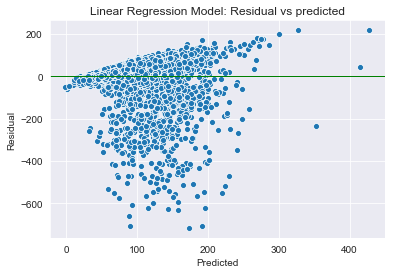

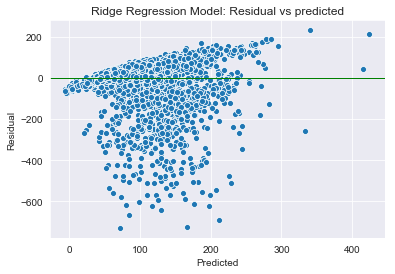

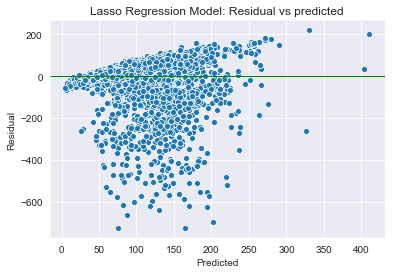

In [31]:
def residual_plot(pred, actual, model):
    """
    Helper function to draw residual plot.
    """
    residual = pred - actual
    sns.scatterplot(pred, residual)
    plt.title('%s Model: Residual vs predicted' % (model))
    plt.xlabel('Predicted')
    plt.ylabel('Residual')
    plt.axhline(y=0, linewidth=1, color='g')
    plt.show()
    
residual_plot(lr_pred, y_test, 'Linear Regression')
residual_plot(ridge_pred, y_test, 'Ridge Regression')
residual_plot(lasso_pred, y_test, 'Lasso Regression')

## Inadequacy of Linear Regression Model on the Dataset
___
After the extensive analysis of the Multiple Linear Regression model, coupled with various Regularization techniques; it is observed that the model fails to give a fairly accurate prediction on the dataset with scores lower than `0.2`.

In the next cells, efforts are made to validate the failure of the Linear Regression Model on this dataset.

### 1. Linearity
There is little or no linear relationship between the actual and predicted values.

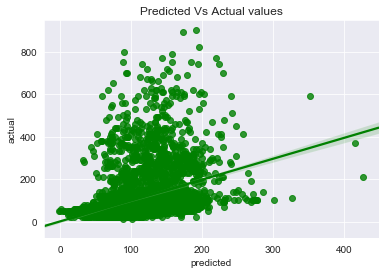

In [32]:
sns.regplot(lr_pred, y_test, color='green')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('Predicted Vs Actual values')
plt.show()

### 2. Homoscedasticity
The residuals are not equidistant for their respective predicted values.

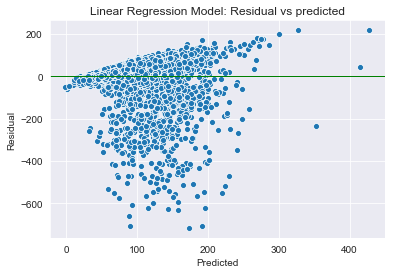

In [33]:
residual_plot(lr_pred, y_test, 'Linear Regression')

### 3. Features Correlation
There are many features that have high correlations with one another, thereby failing the Independence of Features clause.

Text(0.5, 1.0, 'Correlation chart of all the features')

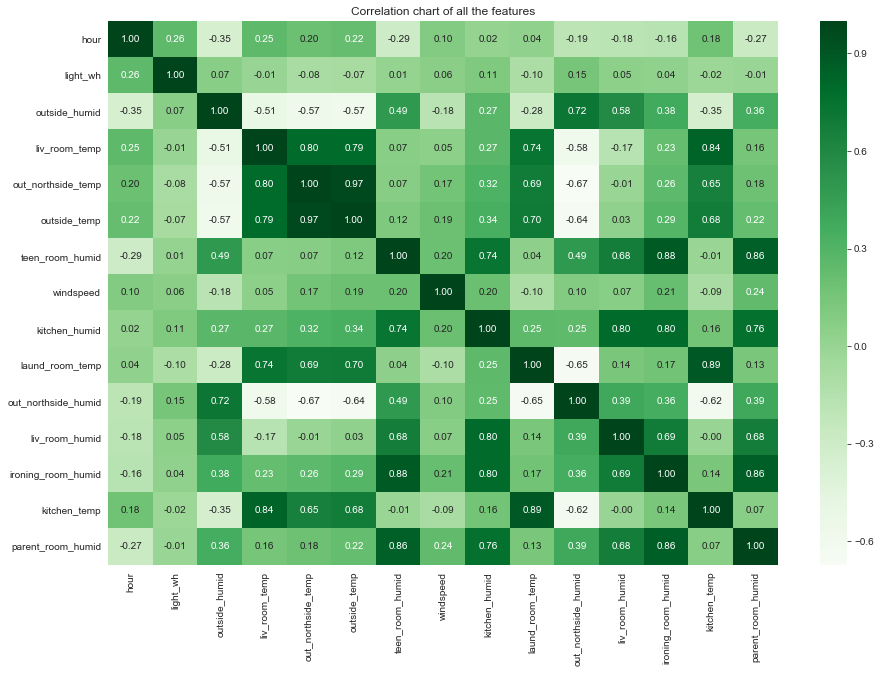

In [34]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(data[features].corr(), annot=True, fmt='.2f', ax=ax, cmap='Greens')
plt.title('Correlation chart of all the features')

### 4. Normality
The residuals distribution is highly skewed, as opposed to being Normal.

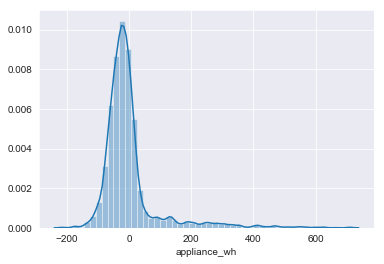

In [35]:
sns.distplot(y_test - lr_pred)